# imports

In [64]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
import sys
#%matplotlib notebook
%matplotlib inline
#from bokeh.io import output_notebook

from typing import Dict, List, Callable, Tuple, Union, Sequence


sys.path.append('../../wsi_processing_pipeline/')
sys.path.append('../../wsi_processing_pipeline/tile_extraction/')
import tile_extraction
from tile_extraction import tiles, util, slide
import wsi_processing_pipeline
from wsi_processing_pipeline import shared
from wsi_processing_pipeline.shared import roi


import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
from itertools import groupby
from tqdm.notebook import tqdm
import cv2
import random
import scipy.io
import json
import pickle
import math
import multiprocessing

seed = 19
np.random.seed(seed)

import cytomine
from cytomine import Cytomine
from cytomine.models import CurrentUser, Project, ProjectCollection, ImageInstanceCollection, AnnotationCollection
from cytomine.models import Annotation, AnnotationTerm
from cytomine.models.ontology import Ontology, Term, RelationTerm, TermCollection, OntologyCollection


import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
from typing import List
import shapely
from shapely import wkt
from shapely.affinity import affine_transform


WSI_BASE_PATH = Path(f'./wsi')
WSI_MUSCLE_PATH = WSI_BASE_PATH/'muscles'

# connect with cytomine server

In [39]:
#TODO read from private file
host = 
public_key = 
private_key = 

with Cytomine(host, public_key, private_key) as cytomine_connection:
    # We are connected !
    me = CurrentUser().fetch()

    # It will print your username, that has been retrieved from Cytomine.
    print(me.username)

[2022-05-06 14:21:02,176][INFO] [GET] [currentuser] CURRENT USER - 61 : admin | 200 OK
[2022-05-06 14:21:02,207][INFO] [GET] [currentuser] CURRENT USER - 61 : admin | 200 OK
admin


# fetch project and image(s)

In [40]:
projects = ProjectCollection().fetch()
print(projects)
for project in projects:
    print(project)

[2022-05-06 14:21:10,084][INFO] [GET] [project collection] 1 objects | 200 OK
[project collection] 1 objects
[project] 1629 : Muscles


In [41]:
project_id = 1629

In [42]:
project = Project().fetch(id=project_id)

[2022-05-06 14:21:11,283][INFO] [GET] [project] 1629 : Muscles | 200 OK


In [43]:
image_instances = ImageInstanceCollection().fetch_with_filter("project", project_id)

[2022-05-06 14:21:12,016][INFO] [GET] [imageinstance collection] 1 objects | 200 OK


In [44]:
for image in image_instances:
    print(image.id)
    print(image.filename)

1644
/1651667219863/DKO476_US_wt_7_HE.ndpi


In [45]:
Path(image.filename).name

'DKO476_US_wt_7_HE.ndpi'

In [46]:
image = image_instances[0]

In [47]:
wsi_path = WSI_MUSCLE_PATH/f'{Path(image.filename).name}';wsi_path

PosixPath('wsi/muscles/DKO476_US_wt_7_HE.ndpi')

In [48]:
image.download(str(wsi_path), override=False)

True

# export rois  to cytomine which were created in QuPath

In [49]:
BATCH_BASE = Path(f'/home/Deep_Learner/private/datasets/muscles/batch_4')
BATCH_ROIS = BATCH_BASE/'rois'

In [50]:
json_paths = BATCH_ROIS.ls()

In [51]:
json_path = None
for p in json_paths:
    if(p.stem == wsi_path.stem):
        json_path = p
print(wsi_path)
print(json_path)

wsi/muscles/DKO476_US_wt_7_HE.ndpi
/home/Deep_Learner/private/datasets/muscles/batch_4/rois/DKO476_US_wt_7_HE.json


In [52]:
class __PolygonHelper:
    def __init__(self, level:int, vertices:Sequence[Tuple[float, float]], labels:List[Union[int,str]]=None):
        self.level = level
        self.vertices = vertices
        self.labels = labels

vs_failed_1 = []
vs_failed_2 = []
vs_failed_3 = []
        
def batch_3_get_polygons_from_json(json_path:pathlib.Path)->List[__PolygonHelper]:
    """
    Reads the json file and returns a list of __PolygonHelper objects. 
    This should be a specialized function for the specific structure of your json files.
    
    Arguments:
        json_path: path to json file
        
    Returns:
        List of __PolygonHelper objects
    """
    polygons = []
    with open(json_path) as json_file:
        for i, annotation in enumerate(json.load(json_file)):
            #some annotations do not have a "classification" prop
            # => just skip them
            try:
                annotation["properties"]["classification"]
            except KeyError as ke:
                print(ke)
                print(f'annotation num: {i}')
                continue
                
            roi_label = annotation["properties"]["classification"]["name"]

            if(annotation["geometry"]["type"] == 'MultiPolygon'):
                multi_polygon_vertices = annotation["geometry"]["coordinates"]
                #print(f'Multi Polygon: {np.array(multi_polygon_vertices).squeeze().shape}')
                ##QuPath produces Polygons and Multipolygons 
                ##(see difference here: https://gis.stackexchange.com/questions/225368/understanding-difference-between-polygon-and-
                ##multipolygon-for-shapefiles-in-qgis/225373)
                ##This loop separates Multipolygons into individual Polygons
                for sub_polygon_vertices in multi_polygon_vertices:
                    sub_polygon_vertices_array = np.array(sub_polygon_vertices, dtype=object).squeeze()
                    if(len(sub_polygon_vertices_array.shape) == 2 and sub_polygon_vertices_array.shape[1] == 2):
                        #print(f'/1/: {sub_polygon_vertices_array.shape}')
                        vs=sub_polygon_vertices_array
                        if(len(vs.shape) == 2):
                            ph = __PolygonHelper(level=0, 
                                            vertices=vs, 
                                            labels=[roi_label])
                            polygons.append(ph)
                        else:
                            vs_failed_1.append(vs)
                        
                    else:
                        for elem in sub_polygon_vertices_array:
                            elem_array = np.array(elem).squeeze()
                            #print(f'/2/: {elem_array.shape}')
                            vs=sub_polygon_vertices_array
                            if(len(vs.shape) == 2):
                                ph = __PolygonHelper(level=0, 
                                                        vertices=vs, 
                                                        labels=[roi_label])
                                polygons.append(ph)
                            else:
                                vs_failed_2.append(vs)
                                #for r in vs:
                                #    ph = __PolygonHelper(level=0, 
                                #                        vertices=r, 
                                #                        labels=[roi_label])
                                #    polygons.append(ph)
                    
            elif(annotation["geometry"]["type"] == 'Polygon'):
                vertices = annotation["geometry"]["coordinates"]
                #print(f'/3/ len of vertices: {len(vertices)}')
                for ls in vertices:               
                    #print(f'/4/: {np.array(ls).squeeze().shape}')
                    vs=np.array(ls, dtype=object).squeeze()
                    if(len(vs.shape) == 2):
                        ph = __PolygonHelper(level=0, 
                                            vertices=vs, 
                                            labels=[roi_label])
                        polygons.append(ph)
                    else:
                        vs_failed_3.append(vs)
            else:
                assert False
                
    ###
    # filter
    ###
    #if(len(polygons) > 200):
    #    print(f'Number of polygons before filtering: {len(polygons)}')
    #    for p in polygons:
    #        sh_poly = shapely.geometry.Polygon(p.vertices)
    #        area = sh_poly.area
    #        if(area < 50000 or len(p.vertices) < 5):
    #            polygons.remove(p)
    #    
    #    print(f'Number of polygons after filtering: {len(polygons)}')
    return polygons

{'M. gastrocnemius', 'M. soleus'}


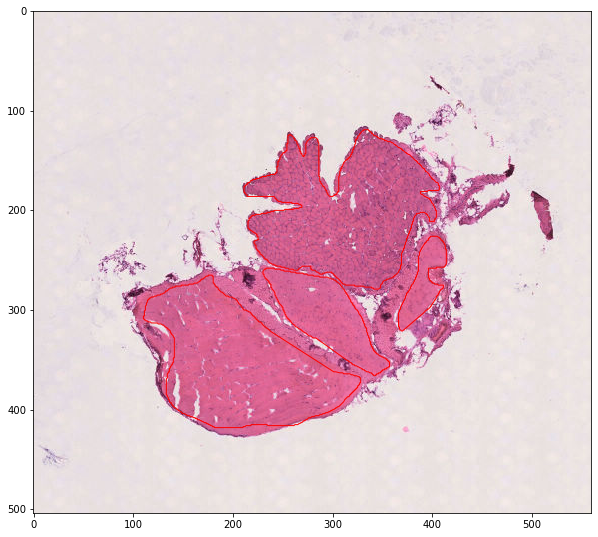

In [53]:
rs = wsi_processing_pipeline.shared.roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path, 
                                                        polygons_from_json_func=batch_3_get_polygons_from_json)
labels = []
for r in rs:
    for l in r.labels:
        labels.append(l)
print(set(labels))
util.show_wsi_with_rois(wsi_path, rs)

In [54]:
import openslide

In [55]:
wsi = openslide.open_slide(str(wsi_path))

In [56]:
wsi.level_dimensions

((17920, 16128),
 (8960, 8064),
 (4480, 4032),
 (2240, 2016),
 (1120, 1008),
 (560, 504),
 (280, 252),
 (140, 126),
 (70, 63))

In [57]:
annotations = AnnotationCollection()
annotations.image = image.id
annotations.fetch()
for a in annotations:
    a.delete()

[2022-05-06 14:26:15,394][INFO] [GET] [annotation collection] 2 objects | 200 OK
[2022-05-06 14:26:16,453][INFO] [DELETE] [annotation] 1961 | 200 OK
[2022-05-06 14:26:16,563][INFO] [DELETE] [annotation] 1801 | 200 OK


In [21]:
label_name_to_term_id = {'M. soleus': 10280, 'M. gastrocnemius': 10288, 'nucleus': 85436}

for r in rs:
    poly = r.get_shapely_polygon_adjusted_to_origin_upper_left(wsi_height=wsi.dimensions[1], wsi_height_level=0)
    anno = Annotation(location=poly.wkt, id_image=image.id).save()
    for l in r.labels:
        AnnotationTerm(anno.id, label_name_to_term_id[l]).save()

[2022-04-25 12:19:33,431][INFO] [POST] [annotation] 86637 | 200 OK
[2022-04-25 12:19:33,460][INFO] [POST] [annotationterm] Annotation 86637 - Term 10280 | 200 OK
[2022-04-25 12:19:33,511][INFO] [POST] [annotation] 86650 | 200 OK
[2022-04-25 12:19:33,538][INFO] [POST] [annotationterm] Annotation 86650 - Term 10288 | 200 OK
[2022-04-25 12:19:33,595][INFO] [POST] [annotation] 86663 | 200 OK
[2022-04-25 12:19:33,622][INFO] [POST] [annotationterm] Annotation 86663 - Term 10288 | 200 OK
[2022-04-25 12:19:33,683][INFO] [POST] [annotation] 86676 | 200 OK
[2022-04-25 12:19:33,712][INFO] [POST] [annotationterm] Annotation 86676 - Term 10288 | 200 OK


# fetch rois back from cytomine (just for showcasing)

In [22]:
annotations = AnnotationCollection()
annotations.image = image.id
annotations.fetch()

[2022-04-25 12:19:33,777][INFO] [GET] [annotation collection] 4 objects | 200 OK


In [23]:
rois_from_cytomine = []
term_id_to_label_name = {10280: 'M. soleus', 10288: 'M. gastrocnemius', 74146:'top_tile'}
for a in annotations:
    a.fetch()    
    labels = []
    for t in a.term:
        labels.append(term_id_to_label_name[t])
        
    poly = util.switch_origin_of_shapely_polygon(polygon=wkt.loads(a.location), 
                                            polygon_level=0, 
                                            wsi_height=wsi.dimensions[1], 
                                            wsi_height_level=0)
    
    r = roi.RegionOfInterestPolygon(roi_id=a.id, 
                            vertices=util.polygon_to_numpy(poly), 
                            level=0,
                            labels=labels)
    rois_from_cytomine.append(r)

[2022-04-25 12:19:33,862][INFO] [GET] [annotation] 86676 | 200 OK
[2022-04-25 12:19:33,893][INFO] [GET] [annotation] 86663 | 200 OK
[2022-04-25 12:19:33,922][INFO] [GET] [annotation] 86650 | 200 OK
[2022-04-25 12:19:33,947][INFO] [GET] [annotation] 86637 | 200 OK


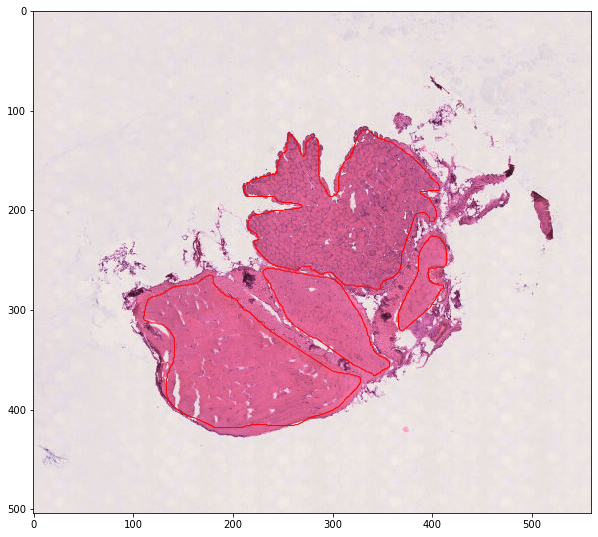

In [24]:
util.show_wsi_with_rois(wsi_path, rois_from_cytomine)

# Add nuclei predictions

## some funcs

In [25]:
def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
    
def naming_func_muscles(wsi_path:pathlib.Path):
    return Path(wsi_path).stem

def __scoring_function_muscle(tissue_percent, combined_factor):
    """
    This favors pink over purple regions (muscle tissue has few nuclei and lots of sarcoplam, which
    is pink in H&E staining). color_factor and s_and_v_factor are higher, 
    the more hematoxylin stained tissue is in the image
    """
    if(combined_factor == 0):
        return tissue_percent / 2
    else:
        return (100/(combined_factor)) * tissue_percent / 100   

    
def scoring_function_muscle(tile_pil:PIL.Image.Image)->Tuple[float, Dict]:
    """
    Arguments:
        tile_pil: The tile as a PIL Image
    Return:
        The tile's score and a dictionary with all factors that were calculated from the PIL Image and 
        used for calculating the score.
    """
    tile_pil_filtered = tile_extraction.filter.filter_img(tile_pil)
    if(tile_pil_filtered is None):
        return 0.0, None
    
    tile_np = pil_to_np_rgb(tile_pil)
    tile_np_filtered = pil_to_np_rgb(tile_pil_filtered)
    tissue_percentage = tile_extraction.filter.tissue_percent(tile_np_filtered)
    
    color_factor = hsv_purple_pink_factor(tile_np)
    s_and_v_factor = hsv_saturation_and_value_factor(tile_np)
    
    combined_factor = color_factor * s_and_v_factor   
    score = __scoring_function_muscle(tissue_percentage, combined_factor)
                    
    # scale score to between 0 and 1
    score = 1.0 - (10.0 / (10.0 + score))
                  
    return score, {"color_factor":color_factor, "s_and_v_factor":s_and_v_factor} 

## tilesummary

In [26]:
wsi_path

PosixPath('wsi/muscles/DKO476_US_wt_7_HE.ndpi')

In [27]:
tilesummary_path = Path(f'/home/Deep_Learner/private/nuclei_detection/tilesummaries/batch_4/DKO476_US_wt_7_HE_tilesummary.pickle')

In [28]:
ts = load_pickle(tilesummary_path)

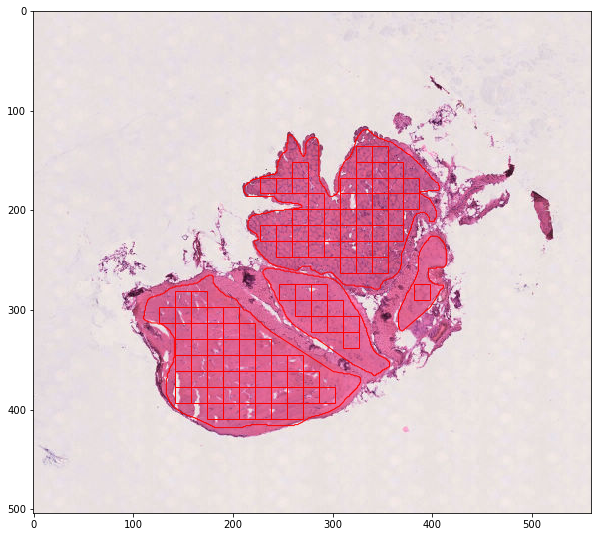

In [29]:
ts.show_wsi_with_top_tiles()

In [30]:
top_tile_term_id = 74146  #term id for the term 'top_tile'

In [31]:
annotations = AnnotationCollection()
annotations.image = image.id
annotations.fetch()
for a in annotations:
    a.fetch()
    if(top_tile_term_id in a.term):
        a.delete()

[2022-04-25 12:19:37,760][INFO] [GET] [annotation collection] 4 objects | 200 OK
[2022-04-25 12:19:37,778][INFO] [GET] [annotation] 86676 | 200 OK
[2022-04-25 12:19:37,793][INFO] [GET] [annotation] 86663 | 200 OK
[2022-04-25 12:19:37,808][INFO] [GET] [annotation] 86650 | 200 OK
[2022-04-25 12:19:37,824][INFO] [GET] [annotation] 86637 | 200 OK


In [36]:
wsi.level_dimensions

((17920, 16128),
 (8960, 8064),
 (4480, 4032),
 (2240, 2016),
 (1120, 1008),
 (560, 504),
 (280, 252),
 (140, 126),
 (70, 63))

In [35]:
wsi.dimensions[1]

16128

In [32]:
for t in ts.top_tiles():
    poly = util.switch_origin_of_shapely_polygon(polygon=t.rectangle.polygon(), 
                                      polygon_level=t.level, 
                                      wsi_height=wsi.dimensions[1], 
                                      wsi_height_level=0)   
    anno = Annotation(location=poly.wkt, id_image=image.id).save()   
    AnnotationTerm(anno.id, top_tile_term_id).save()
    #for l in t.labels:
     #   AnnotationTerm(anno.id, label_name_to_term_id[l]).save()
    

[2022-04-25 12:19:37,978][INFO] [POST] [annotation] 86689 | 200 OK
[2022-04-25 12:19:38,009][INFO] [POST] [annotationterm] Annotation 86689 - Term 74146 | 200 OK
[2022-04-25 12:19:38,049][INFO] [POST] [annotation] 86702 | 200 OK
[2022-04-25 12:19:38,079][INFO] [POST] [annotationterm] Annotation 86702 - Term 74146 | 200 OK
[2022-04-25 12:19:38,117][INFO] [POST] [annotation] 86715 | 200 OK
[2022-04-25 12:19:38,146][INFO] [POST] [annotationterm] Annotation 86715 - Term 74146 | 200 OK
[2022-04-25 12:19:38,180][INFO] [POST] [annotation] 86728 | 200 OK
[2022-04-25 12:19:38,207][INFO] [POST] [annotationterm] Annotation 86728 - Term 74146 | 200 OK
[2022-04-25 12:19:38,244][INFO] [POST] [annotation] 86741 | 200 OK
[2022-04-25 12:19:38,275][INFO] [POST] [annotationterm] Annotation 86741 - Term 74146 | 200 OK
[2022-04-25 12:19:38,312][INFO] [POST] [annotation] 86754 | 200 OK
[2022-04-25 12:19:38,339][INFO] [POST] [annotationterm] Annotation 86754 - Term 74146 | 200 OK
[2022-04-25 12:19:38,375][IN

[2022-04-25 12:19:41,220][INFO] [POST] [annotation] 87352 | 200 OK
[2022-04-25 12:19:41,248][INFO] [POST] [annotationterm] Annotation 87352 - Term 74146 | 200 OK
[2022-04-25 12:19:41,289][INFO] [POST] [annotation] 87365 | 200 OK
[2022-04-25 12:19:41,320][INFO] [POST] [annotationterm] Annotation 87365 - Term 74146 | 200 OK
[2022-04-25 12:19:41,357][INFO] [POST] [annotation] 87378 | 200 OK
[2022-04-25 12:19:41,385][INFO] [POST] [annotationterm] Annotation 87378 - Term 74146 | 200 OK
[2022-04-25 12:19:41,419][INFO] [POST] [annotation] 87391 | 200 OK
[2022-04-25 12:19:41,446][INFO] [POST] [annotationterm] Annotation 87391 - Term 74146 | 200 OK
[2022-04-25 12:19:41,485][INFO] [POST] [annotation] 87404 | 200 OK
[2022-04-25 12:19:41,514][INFO] [POST] [annotationterm] Annotation 87404 - Term 74146 | 200 OK
[2022-04-25 12:19:41,549][INFO] [POST] [annotation] 87417 | 200 OK
[2022-04-25 12:19:41,577][INFO] [POST] [annotationterm] Annotation 87417 - Term 74146 | 200 OK
[2022-04-25 12:19:41,612][IN

[2022-04-25 12:19:44,454][INFO] [POST] [annotation] 88015 | 200 OK
[2022-04-25 12:19:44,483][INFO] [POST] [annotationterm] Annotation 88015 - Term 74146 | 200 OK
[2022-04-25 12:19:44,518][INFO] [POST] [annotation] 88028 | 200 OK
[2022-04-25 12:19:44,546][INFO] [POST] [annotationterm] Annotation 88028 - Term 74146 | 200 OK
[2022-04-25 12:19:44,581][INFO] [POST] [annotation] 88041 | 200 OK
[2022-04-25 12:19:44,610][INFO] [POST] [annotationterm] Annotation 88041 - Term 74146 | 200 OK
[2022-04-25 12:19:44,645][INFO] [POST] [annotation] 88054 | 200 OK
[2022-04-25 12:19:44,673][INFO] [POST] [annotationterm] Annotation 88054 - Term 74146 | 200 OK
[2022-04-25 12:19:44,707][INFO] [POST] [annotation] 88067 | 200 OK
[2022-04-25 12:19:44,734][INFO] [POST] [annotationterm] Annotation 88067 - Term 74146 | 200 OK
[2022-04-25 12:19:44,767][INFO] [POST] [annotation] 88080 | 200 OK
[2022-04-25 12:19:44,797][INFO] [POST] [annotationterm] Annotation 88080 - Term 74146 | 200 OK


## nuclei

In [38]:
dataset_dicts_path = Path(f'/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/')

In [39]:
dataset_dicts_path.ls()

[PosixPath('/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/wsi:-DKO476_US_wt_7_HE.ndpi;-[Tile-#94,-Score-0.9808].pickle'),
 PosixPath('/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/wsi:-DKO476_US_wt_7_HE.ndpi;-[Tile-#101,-Score-0.9798].pickle'),
 PosixPath('/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/wsi:-DKO476_US_wt_7_HE.ndpi;-[Tile-#74,-Score-0.9778].pickle'),
 PosixPath('/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/wsi:-DKO476_US_wt_7_HE.ndpi;-[Tile-#63,-Score-0.9748].pickle'),
 PosixPath('/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/wsi:-DKO476_US_wt_7_HE.ndpi;-[Tile-#67,-Score-0.9660].pickle'),
 PosixPath('/home/Deep_Learner/private/nuclei_detection/dataset_dicts/batch_4_with_preds/DKO476_US_wt_7_HE/wsi:-DKO476_US_wt_7_HE.ndpi;-[Tile-#7